In [1]:
import argparse
import random
import torch
import numpy as np
import os
import pandas as pd
from monai.transforms import (
    Compose, Resized, ToTensord, NormalizeIntensityd, 
    apply_transform, CenterSpatialCropd, RandScaleIntensityd,
    ScaleIntensityd, RandSpatialCropd, RandFlipd)
from pylab import rcParams
import matplotlib
import matplotlib.pyplot as plt
if "RTX 20" not in torch.cuda.get_device_name(0): matplotlib.use('Agg')
from monai.networks.nets import UNet, SegResNet, UNETR
from monai.losses import DiceLoss
from tqdm import tqdm
from skimage import measure
import trimesh


def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)  
    torch.cuda.manual_seed(seed)  
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True
    
class MandibleData(torch.utils.data.Dataset):
    def __init__(self, csv, args, mode, get_original=False):
        self.csv = csv.reset_index(drop=True)
        self.mode = mode
        self.get_original = get_original
        self.args = args
    def __len__(self):
        return len(self.csv)
    def __getitem__(self, index):
        row = self.csv.iloc[index]
        img_dir = os.path.join(self.args.input_path, "npy", f"{row.ID}_image.npy").replace(" ","")
        mask_dir = os.path.join(self.args.input_path, "npy", f"{row.ID}_mask.npy").replace(" ","")
        image = np.load(img_dir) # T, H, W 
        mask = np.load(mask_dir) # T, H, W
        image = np.transpose(image, (1,2,0)) # H, W, T
        mask = np.transpose(mask, (1,2,0)) # H, W, T
        
        if self.args.cut_z < 1:
            num_slices = image.shape[2]
            cut_slices = int(num_slices*self.args.cut_z)
            image=image[:,:,:cut_slices]
            mask=mask[:,:,:cut_slices]            

        data=dict()
        data["image"]=image[np.newaxis,:,:,:] # C, H, W, T
        data["mask"]=mask[np.newaxis,:,:,:] # C, H, W, T
        img_shape = image.shape
        transform = self.get_transform(img_shape, mode=self.mode)
        data = apply_transform(transform, data)
        data['id'] = row.ID
        return data
        
    def get_transform(self, image_size, mode='train'):
        if mode=="train":
            transform = Compose([
                RandSpatialCropd(keys=["image","mask"], roi_size=[int(image_size[0]*self.args.rand_crop),
                                                                   int(image_size[1]*self.args.rand_crop),
                                                                   int(image_size[2]*self.args.rand_crop)], random_size=False),
                Resized(keys=["image","mask"],spatial_size=(self.args.resize_h, self.args.resize_w, self.args.resize_t),mode = "area"),
                RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=1),
                ScaleIntensityd(keys=["image"]), # Change pixels range 0 to 1
                NormalizeIntensityd(keys=["image"], nonzero=False, channel_wise=False),    
                ToTensord(keys=["image", "mask"]),
                ])
        else:
            transform = Compose([
                Resized(keys=["image", "mask"],spatial_size=(self.args.resize_h, self.args.resize_w, self.args.resize_t),mode = "area"),
                ScaleIntensityd(keys=["image"]), # Change pixels range 0 to 1
                NormalizeIntensityd(keys=["image"], nonzero=False, channel_wise=False),   
                ToTensord(keys=["image", "mask"]),
                ])
        return transform
    
def val_epoch(model, loader):
    model.eval()
    val_loss={}

    bar = tqdm(loader)
    val_loss = []
    val_dice = []
    with torch.no_grad():
        for data in bar: #B, C, H, W, T
            images = data['image'].to(device) # 2B, C, H, W, T 
            masks = data["mask"].to(device) # 2B, C, H, W, T
            logits = model(images)
            dice_loss = criterion(logits, masks)
            if not args.bce_lambda > 0:
                bce_loss = F.binary_cross_entropy_with_logits(outputs, masks)
                total_loss = dice_loss + bce_loss * args.bce_lambda
            else:
                total_loss = dice_loss
            val_loss.append(total_loss.detach().cpu().numpy().item())
            probs = logits.sigmoid().detach().cpu()
            masks = masks.detach().cpu()
            del logits
            probs[probs > 0.5] = 1
            probs[probs <= 0.5] = 0
            probs = probs.type(torch.uint8)
            _, dice = get_iou_dice(probs.squeeze(1), masks.squeeze(1), SMOOTH = 1e-6)
            dice = dice.mean().item()
            val_dice.append(dice)
            del images, masks, dice_loss, probs, dice
        val_loss = np.mean(val_loss)
        val_dice = np.mean(val_dice)
    return val_loss, val_dice

def make_mesh(image, threshold=-300, step_size=1):
    p=image    
    verts, faces, norm, val = measure.marching_cubes(p, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces

def get_iou_dice(preds, targets, SMOOTH = 1e-6):
    preds = preds>0.5
    targets = targets.type(torch.bool)
    intersection = (preds & targets).float().sum((1, 2, 3))
    union = (preds | targets).float().sum((1, 2, 3)) 
    mask_sum = (preds.float() + targets.float()).sum((1, 2, 3))
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    dice = (2 * (intersection + SMOOTH)) / (mask_sum + SMOOTH)
    return iou, dice

In [2]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--SEED', type=int, default= 410)
    parser.add_argument('--input_path', type=str, default='../data/process/total/')
    parser.add_argument('--output_path', type=str, default='../outputs/')
    parser.add_argument('--suffix', type=str, default='test_220117')
    parser.add_argument('--fold', type=int, default=1)
    parser.add_argument('--DEBUG', type=str, default="F")
    parser.add_argument("--batch_size", type=int, default=8)
    parser.add_argument("--weight_dir", type=str, default="../outputs/test_220117/best_dice01.pth") 
    parser.add_argument("--num_workers", type=int, default=0)
    parser.add_argument("--cut_z", type=float, default=0.6)
    parser.add_argument("--resize_h", type=int, default=64) # 96, 128 160
    parser.add_argument("--resize_w", type=int, default=64) # 96, 128 160
    parser.add_argument("--resize_t", type=int, default=32) # 96, 64 160
    parser.add_argument('--plt_show', type=str, default="T")
    parser.add_argument('--model', type=str, default="segresnet") # unet, segresnet, unetr
    args, _ = parser.parse_known_args()
    print(args)

Namespace(DEBUG='F', SEED=410, batch_size=8, cut_z=0.6, fold=1, input_path='../data/process/total/', model='segresnet', num_workers=0, output_path='../outputs/', plt_show='T', resize_h=64, resize_t=32, resize_w=64, suffix='test_220117', weight_dir='../outputs/test_220117/best_dice01.pth')


In [3]:
set_seed(seed=args.SEED)
output_path = os.path.join(args.output_path, args.suffix)
os.makedirs(output_path, exist_ok=True)

set_dir = os.path.join(output_path, f'inference_set{args.fold:02d}.txt')
with open(set_dir, 'w') as appender: 
    appender.write(str(args) + '\n')  
    
npy_dir = os.path.join(output_path, "npy")
os.makedirs(npy_dir, exist_ok=True)

stl_dir = os.path.join(output_path, "stl")
os.makedirs(stl_dir, exist_ok=True)


    
df = pd.read_csv(os.path.join(args.input_path,"total_data.csv"))
df['fold'] = df.index % 5 + 1 

df_val = df[(df['fold'] == args.fold)].reset_index(drop=True)
df_val = df_val.sample(frac = 1).reset_index(drop=True) 

metric_path = os.path.join(output_path, f'metrics_{args.fold:02d}.txt')
with open(metric_path, 'w') as appender: 
    appender.write(f'Validation data (n={len(df_val)}) Average ±STD\n')  

if args.DEBUG == "T":
    print('DEBUGING...')
    df_val = df_val[0:5]
    
dataset_val = MandibleData(df_val, args, "val")   
loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)


torch.Size([1, 64, 64, 32])
torch.Size([1, 64, 64, 32])
torch.Size([1, 64, 64, 32])
torch.Size([1, 64, 64, 32])


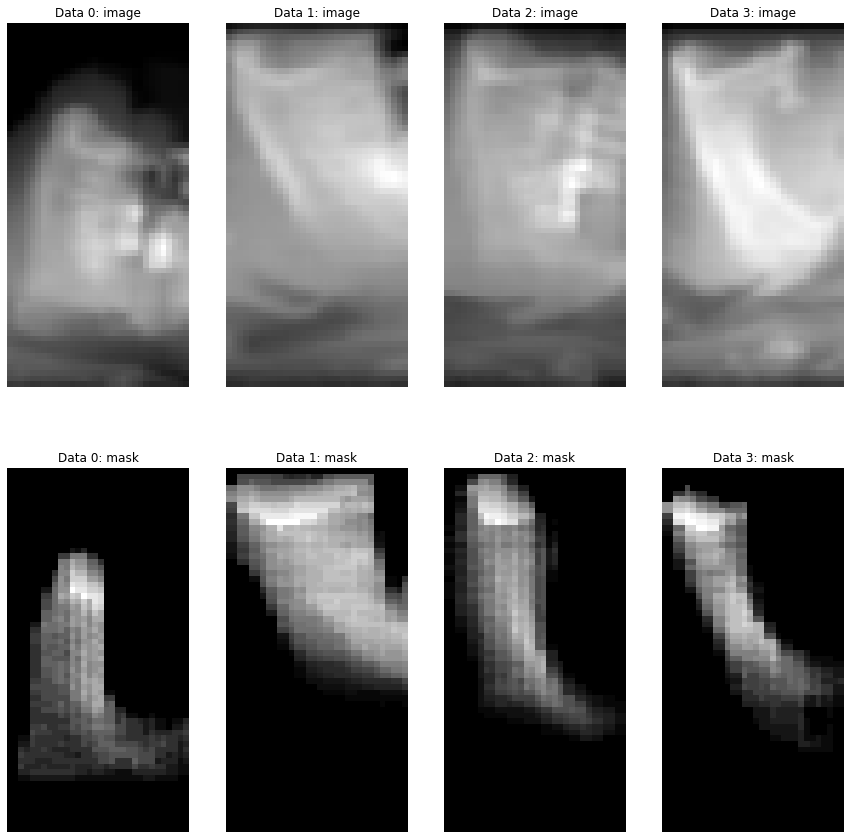

In [4]:
if args.plt_show=="T":
    rcParams['figure.figsize'] = 15,15
    f, axarr = plt.subplots(2,4)
    for idx in range(4):
        data = loader_val.dataset[idx]
        print(data['image'].shape)
        for j, img in enumerate(['image', 'mask']):
            data[img] = data[img].squeeze().sum(axis=1)
            axarr[j, idx].imshow(data[img], cmap='gray')
            axarr[j, idx].axis("off")
            axarr[j, idx].set_title(f"Data {idx}: {img}")

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.cuda.is_available(): scaler = torch.cuda.amp.GradScaler()
if args.model == 'unet':
    model = UNet(
        dimensions=3,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)
elif args.model == 'segresnet':
    model = SegResNet(
        blocks_down=[1, 2, 2, 4],
        blocks_up=[1, 1, 1],
        init_filters=16,
        in_channels=1,
        out_channels=1,
        dropout_prob=0.2,
        ).to(device)
elif args.model == 'unetr':
    model = UNETR(
        in_channels=1,
        out_channels=1,
        img_size=(args.resize_h, args.resize_w, args.resize_t),
        feature_size=16, # 16
        hidden_size=768, # 768
        mlp_dim=3072, # 3072
        num_heads=12, # 12
        pos_embed="perceptron",
        norm_name="instance",
        res_block=True,
        dropout_rate=0.0,
        ).to(device)
    
if args.weight_dir is not None: 
    print(f"Load '{args.weight_dir}'...")
    try:  # single GPU model_file
        model.load_state_dict(torch.load(args.weight_dir), strict=True)
    except:  # multi GPU model_file
        state_dict = torch.load(args.weight_dir)
        state_dict = {k[7:] if k.startswith('module.') else k: state_dict[k] for k in state_dict.keys()}
        model.load_state_dict(state_dict, strict=True)

if torch.cuda.device_count() > 1: model = torch.nn.DataParallel(model)
    
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
contents = f"Model: {args.model} // Total parameter: {format(total_params, ',d')} // Trainable parameter: {format(trainable_params, ',d')}"
print(contents)
with open(set_dir, 'a') as appender: appender.write(contents+"\n")  


Load '../outputs/test_220117/best_dice01.pth'...
Model: segresnet // Total parameter: 4,700,897 // Trainable parameter: 4,700,897


In [7]:
model.eval()
val_loss={}

bar = tqdm(loader_val)
val_iou = []
val_dice = []
with torch.no_grad():
    for data in bar: #B, C, H, W, T
        images = data['image'].to(device) # B, C, H, W, T 
        masks = data["mask"].to(device) # B, C, H, W, T
        masks = masks.detach().cpu()
        logits = model(images).sigmoid().detach().cpu()
        probs = logits.clone()
        probs[probs > 0.5] = 1
        probs[probs <= 0.5] = 0
        probs = probs.squeeze().detach().cpu()
        images = images.squeeze().detach().cpu()
        for idx in range(len(masks)):
            iou, dice = get_iou_dice(probs[idx], masks[idx], SMOOTH = 1e-6)
            val_iou.append(iou.item())
            val_dice.append(dice.item())
            np.save(os.path.join(npy_dir, f"{data['id'][idx]}.npy"), logits.numpy()[idx])
            upper_img = (images[idx] * (probs[idx] -1)**2).numpy()
            v, f = make_mesh(upper_img, threshold=2.0)
            mesh = trimesh.Trimesh(vertices=v, faces=f)
            mesh.export(os.path.join(stl_dir, f"{data['id'][idx]}_upper.stl"))
            lower_img = probs[idx].numpy()
            v, f = make_mesh(lower_img, threshold=0.0)
            mesh = trimesh.Trimesh(vertices=v, faces=f)
            mesh.export(os.path.join(stl_dir, f"{data['id'][idx]}_lower.stl"))

print(f"IoU: {np.mean(val_iou):.4f} ±{np.std(val_iou):.4f}")
print(f"Dice: {np.mean(val_dice):.4f} ±{np.std(val_dice):.4f}")

with open(metric_path, 'a') as f:
    f.write(f"IoU: {np.mean(val_iou):.4f} ±{np.std(val_iou):.4f}\n")
    f.write(f"Dice: {np.mean(val_dice):.4f} ±{np.std(val_dice):.4f}\n")

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.44it/s]
